In [1]:
# import torch
# print(torch.__version__)
# print(torch.version.cuda)


In [2]:
# !pip install \
#   torch-geometric \
#   torch-scatter \
#   torch-sparse \
#   torch-cluster \
#   torch-spline-conv \
#   -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

# !pip install kagglehub matplotlib scikit-learn pandas


In [3]:
import torch
import torch_geometric
from torch_geometric.nn import GINConv
print("torch:", torch.__version__)
print("pyg:", torch_geometric.__version__)

torch: 2.8.0+cu126
pyg: 2.7.0


In [4]:
# ==========================================================
# Setup inicial — compatível com Colab + A100 (PyTorch 2.8.0+cu126)
# ==========================================================

import os, random, warnings, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.data import Data

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score
)

import kagglehub

# ==========================================================
# Configurações gerais
# ==========================================================
RANDOM_STATE = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

# Se essa linha gerar warning, pode comentar (não é obrigatória)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Seed global para reprodutibilidade
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

warnings.filterwarnings("ignore")

# Seleciona GPU A100 se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device ativo: {device}")
print(f"GPU detectada: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Nenhuma'}")
print(f"Versão Torch: {torch.__version__}")

✅ Device ativo: cuda
GPU detectada: NVIDIA A100-SXM4-80GB
Versão Torch: 2.8.0+cu126


In [5]:
def set_seed_all(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Modo determinístico do PyTorch:
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed_all(RANDOM_STATE)

TRAIN_UPPER_LIMIT = 34
TEST1_LOWER_LIMIT = TRAIN_UPPER_LIMIT + 1
TEST1_UPPER_LIMIT = 42
TEST2_LOWER_LIMIT = 43
TEST2_UPPER_LIMIT = 49

In [6]:
def quick_df_report(df, top_nulls=10, target_col=None, cat_counts_max_unique=20):
    # 1) shape
    print(f"shape: {df.shape}")

    # 2) nulos (visão geral)
    has_nulls = df.isnull().values.any()
    print(f"há valores nulos? {has_nulls}")

    if has_nulls:
        # 3) colunas com nulos (lista) + top-N por % de nulos
        null_cols = df.columns[df.isnull().any()].tolist()
        print(f"colunas com nulos: {null_cols}")

    if has_nulls:
        null_pct = (df.isnull().mean().sort_values(ascending=False) * 100)
        print("\nTOP colunas por % de nulos:")
        print(null_pct.head(top_nulls).round(2).astype(str) + "%")

    # dtypes (resumo)
    print("\nDtypes (contagem):")
    print(df.dtypes.value_counts())

    # linhas duplicadas
    dup_rows = df.duplicated().sum()
    print(f"\nLinhas duplicadas: {dup_rows}")

    # constantes / zero variância
    nunq = df.nunique(dropna=False)
    const_cols = nunq[nunq <= 1].index.tolist()
    print(f"Colunas constantes (nunique<=1): {const_cols}")

    # infinitos (em numéricas)
    num = df.select_dtypes(include=[np.number])
    if not num.empty:
        inf_mask = np.isinf(num)
        has_inf = inf_mask.values.any()
        if has_inf:
            cols_inf = num.columns[inf_mask.any()].tolist()
            print(f"Colunas com ±inf: {cols_inf}")
        else:
            print("Colunas com ±inf: nenhuma")

        # min/max rápidos (útil pra sanity check)
        minmax = pd.DataFrame({
            "min": num.min(numeric_only=True),
            "max": num.max(numeric_only=True)
        })
        print("\nFaixas numéricas (min/max) - primeiras 10:")
        print(minmax.head(10))

    # cardinalidade de categóricas (pode indicar IDs) + value_counts p/ baixa cardinalidade
    obj = df.select_dtypes(include=["object", "category"])
    if not obj.empty:
        card = (obj.nunique(dropna=False) / len(df)).sort_values(ascending=False)
        high_card = card[card > 0.9].index.tolist()
        print(f"\nCategóricas de alta cardinalidade (>90% únicos): {high_card[:10]}{' ...' if len(high_card)>10 else ''}")

        # value_counts para categóricas com baixa cardinalidade
        low_card_cols = [c for c in obj.columns if obj[c].nunique(dropna=False) <= cat_counts_max_unique]
        if low_card_cols:
            print(f"\nValue counts (categóricas com <= {cat_counts_max_unique} categorias):")
            for c in low_card_cols:
                vc = df[c].value_counts(dropna=False)
                pct = (vc / len(df) * 100).round(2).astype(str) + '%'
                out = pd.DataFrame({"count": vc, "pct": pct})
                print(f"\n[{c}]")
                print(out)

    # distribuição do alvo (opcional)
    if target_col and target_col in df.columns:
        print(f"\nDistribuição de '{target_col}':")
        print(df[target_col].value_counts(dropna=False))


# 1) Carregando os Dados

In [7]:
# ==========================================================
# Download do dataset Elliptic via KaggleHub (Colab)
# ==========================================================
# import shutil
# from pathlib import Path
# import kagglehub
# import pandas as pd

# 1. Download
src = kagglehub.dataset_download("ellipticco/elliptic-data-set")
src_path = Path(src)

# 2. Define destino dentro de /content
dst = Path("/content/data/03_elliptic")
dst.mkdir(parents=True, exist_ok=True)

# 3. Se houver subpasta única (ex.: 'elliptic_bitcoin_dataset'), entra nela
subdirs = [p for p in src_path.iterdir() if p.is_dir()]
src_root = subdirs[0] if len(subdirs) == 1 else src_path

# 4. Copia conteúdo pro destino
for item in src_root.iterdir():
    target = dst / item.name
    if item.is_dir():
        shutil.copytree(item, target, dirs_exist_ok=True)
    else:
        shutil.copy2(item, target)

print("✅ Dataset salvo em:", dst.resolve())

# 5. Leitura dos CSVs
df_nodes = pd.read_csv(dst / "elliptic_txs_features.csv", header=None)
df_edges = pd.read_csv(dst / "elliptic_txs_edgelist.csv")
df_target = pd.read_csv(dst / "elliptic_txs_classes.csv")

print(f"Arquivos lidos:\n - Nodes: {df_nodes.shape}\n - Edges: {df_edges.shape}\n - Target: {df_target.shape}")


Using Colab cache for faster access to the 'elliptic-data-set' dataset.
✅ Dataset salvo em: /content/data/03_elliptic
Arquivos lidos:
 - Nodes: (203769, 167)
 - Edges: (234355, 2)
 - Target: (203769, 2)


## 1A) Dataframe de nós

In [8]:
feature_cols = [f'feature_{idx}' for idx in range(1, df_nodes.shape[1] - 1)]
df_nodes.columns = ['txId', 'time_step'] + feature_cols
df_nodes.head()

,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [9]:
quick_df_report(df_nodes)

shape: (203769, 167)
há valores nulos? False

Dtypes (contagem):
float64    165
int64        2
Name: count, dtype: int64

Linhas duplicadas: 0
Colunas constantes (nunique<=1): []
Colunas com ±inf: nenhuma

Faixas numéricas (min/max) - primeiras 10:
                   min           max
txId       1076.000000  4.032446e+08
time_step     1.000000  4.900000e+01
feature_1    -0.172983  7.168197e+01
feature_2    -0.210553  7.359505e+01
feature_3    -1.756361  2.683580e+00
feature_4    -0.121970  4.902760e+01
feature_5    -0.063725  2.600907e+02
feature_6    -0.113002  5.456518e+01
feature_7    -0.061584  1.134409e+02
feature_8    -0.163646  7.335457e+01


In [10]:
# 1. Cria o mapeamento txId → novo ID incremental
id_map = {tid: i for i, tid in enumerate(df_nodes['txId'])}

# 2. Cria a coluna 'node_id' em df_nodes
df_nodes['txId'] = df_nodes['txId'].map(id_map)
df_nodes.head()

,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165
0,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


## 1B) Dataframe de arestas

In [11]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [12]:
quick_df_report(df_edges)

shape: (234355, 2)
há valores nulos? False

Dtypes (contagem):
int64    2
Name: count, dtype: int64

Linhas duplicadas: 0
Colunas constantes (nunique<=1): []
Colunas com ±inf: nenhuma

Faixas numéricas (min/max) - primeiras 10:
        min        max
txId1  1076  403244581
txId2  1076  403244581


In [ ]:
node_ids = set(df_nodes['txId'])
df_edges['txId1'] = df_edges['txId1'].map(id_map)
df_edges['txId2'] = df_edges['txId2'].map(id_map)
df_edges.head()

,txId1,txId2
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9


## 1C) Dataframe com target

In [14]:
df_target.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [15]:
quick_df_report(df_target)

shape: (203769, 2)
há valores nulos? False

Dtypes (contagem):
int64     1
object    1
Name: count, dtype: int64

Linhas duplicadas: 0
Colunas constantes (nunique<=1): []
Colunas com ±inf: nenhuma

Faixas numéricas (min/max) - primeiras 10:
       min        max
txId  1076  403244581

Categóricas de alta cardinalidade (>90% únicos): []

Value counts (categóricas com <= 20 categorias):

[class]
          count     pct
class                  
unknown  157205  77.15%
2         42019  20.62%
1          4545   2.23%


In [16]:
df_target['txId'] = df_target['txId'].map(id_map)
df_target['class'] = df_target['class'].map({'unknown': -1, '1': 1, '2': 0}).astype(int)
df_target.head()

,txId,class
0,0,-1
1,1,-1
2,2,-1
3,3,0
4,4,-1


## 1D) Analisando o Target

In [17]:
df_nodes_with_class = df_nodes.merge(
    df_target[["txId", "class"]].drop_duplicates("txId", keep="last"),
    on="txId", how="left"
)


🧩 Time steps mais anômalos:
|   time_step |   anom_score |   frac_illicit |   frac_licit |   frac_unknown |
|------------:|-------------:|---------------:|-------------:|---------------:|
|          39 |      3.55967 |      0.0293478 |     0.399275 |       0.571377 |
|          29 |      2.62504 |      0.0769591 |     0.197661 |       0.72538  |
|          32 |      2.55605 |      0.0755801 |     0.216796 |       0.707624 |


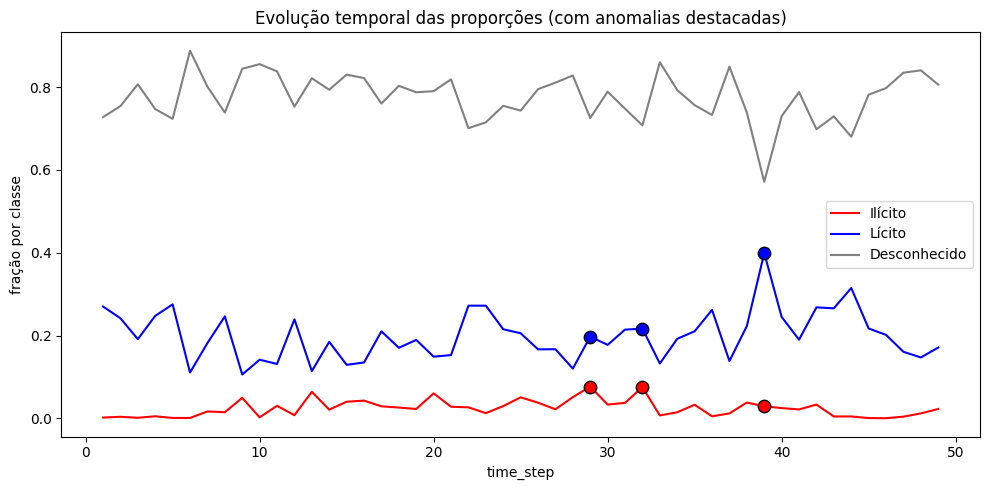

In [18]:
# --- 1. Agrega volumes por time_step e classe ---
df_agg = (
    df_nodes_with_class
    .groupby(['time_step', 'class'], as_index=False)
    .agg(vol=('txId', 'size'))
)

# --- 2. Cria pivot table (linhas=time_step, colunas=class) ---
pivot = (
    df_agg
      .pivot(index="time_step", columns="class", values="vol")
      .sort_index()
      .fillna(0)
)
pivot.columns = [f"class_{c}" for c in pivot.columns]
pivot = pivot.reset_index()  # <- garante que 'time_step' seja coluna

# --- 3. Adiciona total e frações ---
pivot["total"] = pivot[["class_-1", "class_0", "class_1"]].sum(axis=1)
pivot["frac_illicit"] = pivot["class_1"] / pivot["total"]
pivot["frac_licit"]   = pivot["class_0"] / pivot["total"]
pivot["frac_unknown"] = pivot["class_-1"] / pivot["total"]

# --- 4. Calcula médias, desvios e z-scores ---
stats = pivot[["frac_illicit", "frac_licit", "frac_unknown"]].agg(["mean", "std"])
for col in ["frac_illicit", "frac_licit", "frac_unknown"]:
    m, s = stats.loc["mean", col], stats.loc["std", col]
    pivot[f"{col}_z"] = (pivot[col] - m) / s

# --- 5. Score de anomalia = maior desvio absoluto ---
pivot["anom_score"] = pivot[
    [f"{c}_z" for c in ["frac_illicit", "frac_licit", "frac_unknown"]]
].abs().max(axis=1)

# --- 6. Seleciona os time_steps mais anômalos (|z| > 2) ---
anomalous = pivot.loc[
    pivot["anom_score"] > 2,
    ["time_step", "anom_score", "frac_illicit", "frac_licit", "frac_unknown"]
].sort_values("anom_score", ascending=False).reset_index(drop=True)

print("\n🧩 Time steps mais anômalos:")
print(anomalous.to_markdown(index=False))

# --- 7. Visualização das proporções ---
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pivot["time_step"], pivot["frac_illicit"], label="Ilícito", color="red")
ax.plot(pivot["time_step"], pivot["frac_licit"], label="Lícito", color="blue")
ax.plot(pivot["time_step"], pivot["frac_unknown"], label="Desconhecido", color="gray")

# Destaca os outliers
outliers = pivot[pivot["anom_score"] > 2]
ax.scatter(outliers["time_step"], outliers["frac_illicit"], color="red", s=80, edgecolor="k", zorder=3)
ax.scatter(outliers["time_step"], outliers["frac_licit"], color="blue", s=80, edgecolor="k", zorder=3)

ax.set_xlabel("time_step")
ax.set_ylabel("fração por classe")
ax.set_title("Evolução temporal das proporções (com anomalias destacadas)")
ax.legend()
plt.tight_layout()
plt.show()


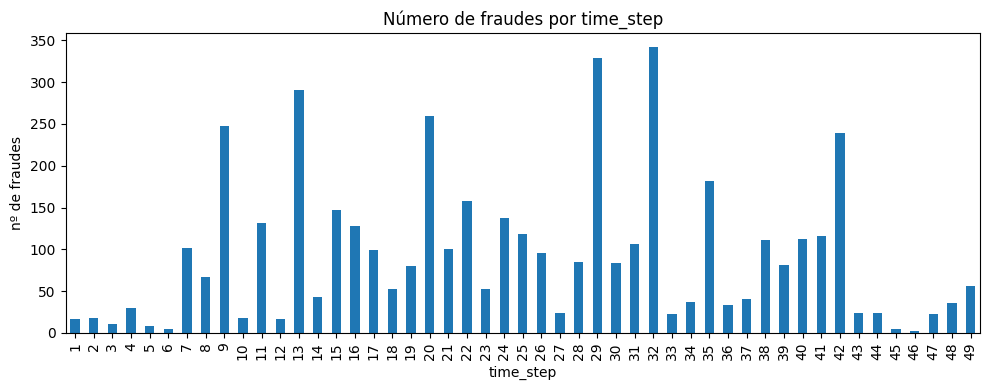

In [19]:
df_agg[df_agg["class"] == 1].plot(
    x="time_step",
    y="vol",
    kind="bar",
    figsize=(10,4),
    legend=False,
    title="Número de fraudes por time_step"
)
plt.xlabel("time_step")
plt.ylabel("nº de fraudes")
plt.tight_layout()
plt.show()

In [20]:
limite = df_agg[df_agg["class"] == 1]["vol"].quantile(0.1)  # 10% mais baixos
poucos = df_agg[(df_agg["class"] == 1) & (df_agg["vol"] <= limite)]
poucos[["time_step", "vol"]]

,time_step,vol
8,3,11
14,5,8
17,6,5
134,45,5
137,46,2


In [21]:
lista_excecoes = list(poucos['time_step'])
lista_excecoes = [45, 46]
lista_excecoes = []

# 2) Modelagem

In [22]:
df_nodes_with_class.shape

(203769, 168)

## 2A) Criando objeto PyG com edges de transações

In [23]:
graphs = []

# Loop por cada time_step (1 a 49)
for t in sorted(df_nodes_with_class['time_step'].unique()):
    if t in lista_excecoes:
        print(f'Time_step {t} excluído por ter poucas fraudes')
        continue

    df_t = df_nodes_with_class[df_nodes_with_class['time_step'] == t]

    # Subconjunto de arestas dentro do mesmo time_step
    edges_t = df_edges[
        df_edges['txId1'].isin(df_t['txId']) &
        df_edges['txId2'].isin(df_t['txId'])
    ].copy()

    # Mapeamento local txId → índice (PyG exige índices contínuos)
    local_node_map = {tx: i for i, tx in enumerate(df_t['txId'])}

    # Aplica o mapeamento e remove pares inválidos
    edges_t['txId1'] = edges_t['txId1'].map(local_node_map)
    edges_t['txId2'] = edges_t['txId2'].map(local_node_map)
    edges_t = edges_t.dropna(subset=['txId1', 'txId2']).astype(int)

    # edge_index (bidirecional, como no paper)
    edge_index = torch.tensor([
        edges_t['txId1'].values,
        edges_t['txId2'].values
    ], dtype=torch.long)
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

    # Features e labels
    x = torch.tensor(df_t[feature_cols].values, dtype=torch.float)
    y = torch.tensor(df_t['class'].values, dtype=torch.long)

    # Criação do objeto PyG
    data = Data(x=x, edge_index=edge_index, y=y)
    data.time_step = t
    data.mask_labeled = (y != -1)  # útil para semi-supervisão

    graphs.append(data)

print(f"{len(graphs)} grafos criados (time_steps {graphs[0].time_step}–{graphs[-1].time_step})")
print(f"Exemplo: {graphs[0]}")


49 grafos criados (time_steps 1–49)
Exemplo: Data(x=[7880, 165], edge_index=[2, 18328], y=[7880], time_step=1, mask_labeled=[7880])


## 2B) Criando dataframes de treino e teste

In [24]:
# ==========================================================
# Divisão temporal em grafos de treino, teste1 e teste2
# ==========================================================

train_graphs = [g for g in graphs if g.time_step <= 34]
test_graphs_1 = [g for g in graphs if 35 <= g.time_step <= 42]  # pré-shutdown
test_graphs_2 = [g for g in graphs if g.time_step >= 43] # pós-shutdown

print(f"Time steps anômalos:", list(poucos['time_step']))
print(f"Treino:   {len(train_graphs)} grafos (1–34)")
print(f"Teste 1:  {len(test_graphs_1)} grafos (35–42)")
print(f"Teste 2:  {len(test_graphs_2)} grafos (43–49)")
print(f"Total:    {len(train_graphs) + len(test_graphs_1) + len(test_graphs_2)} grafos")


Time steps anômalos: [3, 5, 6, 45, 46]
Treino:   34 grafos (1–34)
Teste 1:  8 grafos (35–42)
Teste 2:  7 grafos (43–49)
Total:    49 grafos


In [ ]:
# df_superv = df_nodes_with_class[(df_nodes_with_class['class'] >= 0) & (~df_nodes_with_class['time_step'].isin(lista_excecoes))]
df_superv = df_nodes_with_class[df_nodes_with_class['class'] >= 0]

df_train = df_superv[df_superv["time_step"] <= TRAIN_UPPER_LIMIT]
df_test1 = df_superv[(df_superv["time_step"] >= TEST1_LOWER_LIMIT) & (df_superv["time_step"] <= TEST1_UPPER_LIMIT)]
df_test2 = df_superv[df_superv["time_step"] > TEST1_UPPER_LIMIT]
df_test  = pd.concat([df_test1, df_test2], ignore_index=True)



X_train = df_train[[c for c in df_train.columns if c.startswith("feature_")]]
X_test1 = df_test1[[c for c in df_test1.columns if c.startswith("feature_")]]
X_test2 = df_test2[[c for c in df_test2.columns if c.startswith("feature_")]]
X_test = df_test[[c for c in df_test.columns if c.startswith("feature_")]]

y_train = df_train["class"]
y_test1 = df_test1["class"]
y_test2 = df_test2["class"]

In [26]:
# ==========================================================
# Definição dos conjuntos de features
# ==========================================================
local_features = [f"feature_{i}" for i in range(1, 95)]     # 1–94 → features locais
agg_features   = [f"feature_{i}" for i in range(95, 166)]   # 95–166 → one-hop features
all_features   = local_features + agg_features              # todas

## 2C) GIN - embeddings

In [27]:
# ==========================================================
# 0) Garante que temos as colunas certas
# ==========================================================
# df_nodes: tem ['txId', 'time_step', feature_1 ... feature_165]
# df_target: tem ['txId', 'class'] já mapeado pra {-1,0,1}

feature_cols = [c for c in df_nodes.columns if c.startswith("feature_")]

df_nodes_with_class = df_nodes.merge(
    df_target[["txId", "class"]].drop_duplicates("txId", keep="last"),
    on="txId",
    how="left"
)

# ==========================================================
# 1) Grafo único de pré-treinamento (steps ≤ 34)
# ==========================================================
MAX_TRAIN_STEP = 34  # reafirma

# 1. filtra nós até o step 34
df_train_nodes = df_nodes_with_class[df_nodes_with_class["time_step"] <= MAX_TRAIN_STEP].copy()

# 2. cria um set com os ids desses nós
train_node_ids = set(df_train_nodes["txId"].tolist())

# 3. filtra arestas cujo par (src, dst) está TODO dentro dos steps ≤ 34
df_train_edges = df_edges[
    df_edges["txId1"].isin(train_node_ids) &
    df_edges["txId2"].isin(train_node_ids)
].copy()

# 4. edge_index (não direcionado)
edge_index_train = torch.tensor(
    [
        df_train_edges["txId1"].values,
        df_train_edges["txId2"].values
    ],
    dtype=torch.long
)
edge_index_train = torch.cat([edge_index_train, edge_index_train.flip(0)], dim=1)

# 5. features e labels
x_train_nodes = torch.tensor(
    df_train_nodes[feature_cols].values,
    dtype=torch.float
)

y_train_nodes = torch.tensor(
    df_train_nodes["class"].values,
    dtype=torch.long
)

# 6. máscara de nós rotulados
mask_labeled_train = (y_train_nodes != -1)

# 7. cria objeto Data único
data_train_global = Data(
    x=x_train_nodes,
    edge_index=edge_index_train,
    y=y_train_nodes
)
data_train_global.mask_labeled = mask_labeled_train

print(data_train_global)
print(f"Total de nós (≤34): {data_train_global.num_nodes}")
print(f"Total de arestas (bidirecionais): {data_train_global.num_edges}")
print(f"Nós rotulados: {int(mask_labeled_train.sum())}")
print(
    "Proporção de ilícitos nos rotulados:",
    float((y_train_nodes[mask_labeled_train] == 1).float().mean())
)


Data(x=[136265, 165], edge_index=[2, 313686], y=[136265], mask_labeled=[136265])
Total de nós (≤34): 136265
Total de arestas (bidirecionais): 313686
Nós rotulados: 29894
Proporção de ilícitos nos rotulados: 0.11580919474363327


In [28]:
# ==========================================================
# Augmentations do GCPAL
# ==========================================================

def drop_edges(edge_index, drop_prob: float):
    """
    edge_index: Tensor [2, E]
    drop_prob: probabilidade de remover cada aresta
    retorna: edge_index' com algumas arestas removidas
    """
    E = edge_index.size(1)
    device = edge_index.device
    mask = torch.rand(E, device=device) > drop_prob
    edge_index = edge_index[:, mask]
    return edge_index

def drop_features(x, drop_prob: float):
    """
    x: Tensor [N, F]
    drop_prob: probabilidade de zerar uma feature de um nó
    (igual ao feature dropping do paper: M2 ⊙ X)
    """
    if drop_prob <= 0.0:
        return x
    device = x.device
    N, F = x.size()
    mask = torch.rand(N, F, device=device) > drop_prob
    x_dropped = x * mask
    return x_dropped

# teste rápido nas estruturas que você já tem:
edge_index_test = drop_edges(data_train_global.edge_index, drop_prob=0.3)
x_test = drop_features(data_train_global.x, drop_prob=0.3)

print("edge_index original:", data_train_global.edge_index.size())
print("edge_index dropped :", edge_index_test.size())
print("x original         :", data_train_global.x.size())
print("x dropped          :", x_test.size())


edge_index original: torch.Size([2, 313686])
edge_index dropped : torch.Size([2, 219266])
x original         : torch.Size([136265, 165])
x dropped          : torch.Size([136265, 165])


In [29]:
from torch_geometric.nn import GINConv
from torch import nn

class GINEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # primeira camada
        mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
        )
        self.convs.append(GINConv(mlp))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        # demais camadas
        for _ in range(num_layers - 1):
            mlp = nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
            )
            self.convs.append(GINConv(mlp))
            self.bns.append(nn.BatchNorm1d(hidden_channels))

    def forward(self, x, edge_index):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim),
        )

    def forward(self, x):
        return self.net(x)

in_dim = data_train_global.x.size(1)  # 165
hidden_dim = 128

encoder = GINEncoder(in_channels=in_dim, hidden_channels=hidden_dim).to(device)
proj_head = ProjectionHead(in_dim=hidden_dim, proj_dim=128).to(device)

# forward de teste
x1 = drop_features(data_train_global.x.to(device), drop_prob=0.3)
e1 = drop_edges(data_train_global.edge_index.to(device), drop_prob=0.3)

x2 = drop_features(data_train_global.x.to(device), drop_prob=0.3)
e2 = drop_edges(data_train_global.edge_index.to(device), drop_prob=0.3)

h1 = encoder(x1, e1)
h2 = encoder(x2, e2)

z1 = proj_head(h1)
z2 = proj_head(h2)

print(h1.shape, z1.shape)
print(h2.shape, z2.shape)


torch.Size([136265, 128]) torch.Size([136265, 128])
torch.Size([136265, 128]) torch.Size([136265, 128])


In [30]:
# ==========================================================
# Construção da KNN view (como no paper) — k = 15
# ==========================================================
def build_knn_edge_index(x: torch.Tensor, k: int = 15, batch_size: int = 4096, device=None):
    """
    x: [N, F] (tensor)
    retorna: edge_index_knn [2, E_knn] não-direcionado
    """
    if device is None:
        device = x.device

    x = F.normalize(x, dim=1)
    N = x.size(0)
    knn_src = []
    knn_dst = []

    for start in range(0, N, batch_size):
        end = min(start + batch_size, N)
        x_batch = x[start:end]             # [B, F]
        # similaridade com TODO o conjunto
        sim = torch.matmul(x_batch, x.t())  # [B, N]

        # top-k (k+1 pra tirar o próprio nó)
        vals, idxs = torch.topk(sim, k=k+1, dim=1)
        for i, neighbors in enumerate(idxs):
            src = start + i
            for dst in neighbors.tolist():
                if dst == src:
                    continue
                knn_src.append(src)
                knn_dst.append(dst)

    edge_index_knn = torch.tensor([knn_src, knn_dst], dtype=torch.long, device=device)
    # torna não-direcionado
    edge_index_knn = torch.cat([edge_index_knn, edge_index_knn.flip(0)], dim=1)
    return edge_index_knn


# ----------------------------------------------------------
# construir KNN para o grafo de treino (≤34)
# ----------------------------------------------------------
x_train_full = data_train_global.x.to(device)

edge_index_knn = build_knn_edge_index(
    x_train_full,
    k=15,
    batch_size=4096,   # A100 aguenta isso
    device=device
)

print("edge_index_knn:", edge_index_knn.shape)


edge_index_knn: torch.Size([2, 4088008])


In [31]:
import gc, torch

# coleta lixo do Python
gc.collect()

# libera memória GPU
torch.cuda.empty_cache()

# força desalocação de tensores órfãos
with torch.no_grad():
    torch.cuda.ipc_collect()

print(f"Memória GPU livre: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB / {(torch.cuda.get_device_properties(0).total_memory / 1e9):.2f} GB total")


Memória GPU livre: 82.29 GB / 85.17 GB total


In [32]:
import torch
import torch.nn.functional as F

# ==========================================================
# Contrastive loss tileada (sem N×N completo)
# ==========================================================
def contrastive_loss_tiled(
    z_anchor,           # z1 → âncoras
    z_target,           # z2 → alvos
    pos_lists=None,     # None = positivos = pares correspondentes (diagonal)
    tau: float = 0.5,
    anchor_bs: int = 2048,
    target_bs: int = 32768,
    device=None,
):
    """
    Implementa InfoNCE sem alocar matriz [N, N] completa.

    z_anchor, z_target: [N, D]
    pos_lists: lista de listas com índices positivos (opcional).
               Se None, assume positivos = pares correspondentes (i == j).
    tau: temperatura
    """
    N = z_anchor.size(0)
    if device is None:
        device = z_anchor.device

    z_anchor = F.normalize(z_anchor, dim=1)
    z_target = F.normalize(z_target, dim=1)

    losses = []

    # loop em batches de âncoras
    for a_start in range(0, N, anchor_bs):
        a_end = min(a_start + anchor_bs, N)
        idx_a = torch.arange(a_start, a_end, device=device)
        za = z_anchor[idx_a]  # [Ba, D]

        # ---- 1ª passada: encontra o máximo global pra estabilidade ----
        global_max = None
        for t_start in range(0, N, target_bs):
            t_end = min(t_start + target_bs, N)
            zt = z_target[t_start:t_end]  # [Bt, D]
            sim_chunk = torch.matmul(za, zt.t()) / tau  # [Ba, Bt]
            chunk_max, _ = sim_chunk.max(dim=1, keepdim=True)
            global_max = chunk_max if global_max is None else torch.maximum(global_max, chunk_max)

        # ---- 2ª passada: acumula numerador/denominador ----
        denom = torch.zeros((a_end - a_start,), device=device)
        num = torch.zeros((a_end - a_start,), device=device)

        for t_start in range(0, N, target_bs):
            t_end = min(t_start + target_bs, N)
            zt = z_target[t_start:t_end]
            sim_chunk = torch.matmul(za, zt.t()) / tau
            sim_chunk = sim_chunk - global_max  # estabiliza
            exp_chunk = torch.exp(sim_chunk)
            denom = denom + exp_chunk.sum(dim=1)

            # positivos dentro deste chunk
            for local_i, i in enumerate(idx_a.tolist()):
                if pos_lists is None:
                    # positivo = mesmo índice
                    if t_start <= i < t_end:
                        pos_local = i - t_start
                        num[local_i] += exp_chunk[local_i, pos_local]
                else:
                    pos_i_global = pos_lists[i]
                    pos_in_this_chunk = [j for j in pos_i_global if t_start <= j < t_end]
                    if not pos_in_this_chunk:
                        continue
                    pos_local_idx = torch.tensor(
                        [j - t_start for j in pos_in_this_chunk],
                        device=device,
                        dtype=torch.long
                    )
                    num[local_i] += exp_chunk[local_i, pos_local_idx].sum()

        eps = 1e-8
        loss_batch = -torch.log((num + eps) / (denom + eps))
        losses.append(loss_batch.mean())

    return torch.stack(losses).mean()


In [33]:
# ==========================================================
# Geração de duas views estocásticas (igual ao paper)
# ==========================================================
def make_random_views(data, drop_p_edge=0.3, drop_p_feat=0.3):
    """
    data: objeto Data (PyG)
    drop_p_edge: probabilidade de remover arestas
    drop_p_feat: probabilidade de zerar features
    """
    x1 = drop_features(data.x, drop_p_feat)
    e1 = drop_edges(data.edge_index, drop_p_edge)

    x2 = drop_features(data.x, drop_p_feat)
    e2 = drop_edges(data.edge_index, drop_p_edge)

    return (x1, e1), (x2, e2)

print("✅ Função make_random_views definida.")


✅ Função make_random_views definida.


In [34]:
from collections import defaultdict
import torch

# ==========================================================
# Constrói a lista de positivos por nó a partir de edge_index
# ==========================================================
def build_positive_lists(edge_index: torch.Tensor, num_nodes: int, add_self: bool = True):
    """
    edge_index: tensor [2, E] (CPU ou GPU)
    num_nodes: número total de nós
    add_self: se True, inclui o próprio nó como positivo

    Retorna: lista de comprimento N, onde cada item i é uma lista
             com os índices dos positivos de i (vizinhos em A).
    """
    # garante CPU para iteração eficiente
    if edge_index.is_cuda:
        edge_index = edge_index.detach().cpu()

    pos = defaultdict(set)

    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()

    for s, d in zip(src, dst):
        pos[s].add(d)
        # se o grafo não for estritamente não-direcionado,
        # manter só esta direção é suficiente (já usamos A conforme passado)

    # monta lista final
    pos_lists = []
    for i in range(num_nodes):
        neigh = pos[i]
        if add_self:
            neigh = set(neigh)  # copia
            neigh.add(i)
        pos_lists.append(list(neigh))

    return pos_lists

print("✅ build_positive_lists definida.")


✅ build_positive_lists definida.


In [35]:
import math, torch
import torch.nn.functional as F
from torch import optim
from torch.cuda.amp import autocast, GradScaler

# ==========================================================
# Pré-treinamento contrastivo do GCPAL (tileado, com pos_lists)
# ==========================================================

λ = 0.5          # peso da perda rand–rand
τ = 0.5          # temperatura
lr = 1e-3
max_epochs = 20   # aumente p/ 20 quando quiser replicar o paper
anchor_bs = 2048
target_bs = 32768
patience = 999

optimizer = optim.Adam(
    list(encoder.parameters()) + list(proj_head.parameters()),
    lr=lr
)
scaler = GradScaler()

# listas de positivos (A e A_KNN) — crie uma vez só
pos_lists_struct = build_positive_lists(
    data_train_global.edge_index.to("cpu"),
    num_nodes=data_train_global.num_nodes
)
pos_lists_knn = build_positive_lists(
    edge_index_knn.to("cpu"),
    num_nodes=data_train_global.num_nodes
)

best_loss = math.inf
epochs_no_improve = 0

encoder.train()
proj_head.train()

for epoch in range(1, max_epochs + 1):
    # ---- gera views ----
    (x1, e1), (x2, e2) = make_random_views(data_train_global, 0.3, 0.3)
    e_knn = edge_index_knn

    # ---- forward ----
    with autocast():  # FP16 reduz VRAM
        h1 = encoder(x1.to(device), e1.to(device))
        h2 = encoder(x2.to(device), e2.to(device))
        h_knn = encoder(x2.to(device), e_knn.to(device))

        z1 = proj_head(h1)
        z2 = proj_head(h2)
        z_knn = proj_head(h_knn)

    # ---- perdas contrastivas (tileadas) com positivos corretos ----
    loss_rand = contrastive_loss_tiled(
        z1, z2,
        pos_lists=pos_lists_struct,
        tau=τ,
        anchor_bs=anchor_bs,
        target_bs=target_bs,
        device=device
    )

    loss_knn = contrastive_loss_tiled(
        z1, z_knn,
        pos_lists=pos_lists_knn,
        tau=τ,
        anchor_bs=anchor_bs,
        target_bs=target_bs,
        device=device
    )

    loss = λ * loss_rand + (1 - λ) * loss_knn

    # ---- backward + otimizador ----
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # ---- early stopping simples ----
    if loss.item() < best_loss - 1e-4:
        best_loss = loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"[{epoch:02d}/{max_epochs}] "
          f"loss_rand={loss_rand.item():.4f} | "
          f"loss_knn={loss_knn.item():.4f} | "
          f"loss={loss.item():.4f} | "
          f"best={best_loss:.4f} | no_improve={epochs_no_improve}")

    if epochs_no_improve >= patience:
        print(f"⏹ Early stopping em epoch {epoch} (sem melhora por {patience} épocas).")
        break

print("✅ Pré-treinamento contrastivo finalizado (tileado, A100).")


[01/20] loss_rand=10.6775 | loss_knn=8.6985 | loss=9.6880 | best=9.6880 | no_improve=0
[02/20] loss_rand=10.5972 | loss_knn=8.6256 | loss=9.6114 | best=9.6114 | no_improve=0
[03/20] loss_rand=10.5002 | loss_knn=8.5313 | loss=9.5157 | best=9.5157 | no_improve=0
[04/20] loss_rand=10.3779 | loss_knn=8.4141 | loss=9.3960 | best=9.3960 | no_improve=0
[05/20] loss_rand=10.2162 | loss_knn=8.2674 | loss=9.2418 | best=9.2418 | no_improve=0
[06/20] loss_rand=10.0625 | loss_knn=8.1292 | loss=9.0958 | best=9.0958 | no_improve=0
[07/20] loss_rand=9.9126 | loss_knn=8.0163 | loss=8.9645 | best=8.9645 | no_improve=0
[08/20] loss_rand=9.7995 | loss_knn=7.9341 | loss=8.8668 | best=8.8668 | no_improve=0
[09/20] loss_rand=9.7257 | loss_knn=7.8713 | loss=8.7985 | best=8.7985 | no_improve=0
[10/20] loss_rand=9.6779 | loss_knn=7.8284 | loss=8.7532 | best=8.7532 | no_improve=0
[11/20] loss_rand=9.6521 | loss_knn=7.7999 | loss=8.7260 | best=8.7260 | no_improve=0
[12/20] loss_rand=9.6355 | loss_knn=7.7838 | los

In [36]:
# --- Splits seguros + extração de embeddings ---
import os, torch, numpy as np, pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, coalesce

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # melhor traceback

def make_split_data_safe(df_nodes_with_class, df_edges, feature_cols, lo, hi):
    # Filtra nós do intervalo
    df_nodes_s = df_nodes_with_class[
        (df_nodes_with_class["time_step"] >= lo) &
        (df_nodes_with_class["time_step"] <= hi)
    ][["txId", *feature_cols, "class"]].copy()

    # Mapeamento local (contíguo)
    df_nodes_s = df_nodes_s.sort_values("txId").reset_index(drop=True)
    txids_np = df_nodes_s["txId"].to_numpy()
    txid_to_local = {int(t): i for i, t in enumerate(txids_np)}

    # Filtra arestas internas e reindexa sem NaN
    e1 = df_edges["txId1"].to_numpy(); e2 = df_edges["txId2"].to_numpy()
    mask = np.isin(e1, txids_np) & np.isin(e2, txids_np)
    e1, e2 = e1[mask], e2[mask]
    src = np.fromiter((txid_to_local[int(x)] for x in e1), dtype=np.int64, count=len(e1))
    dst = np.fromiter((txid_to_local[int(x)] for x in e2), dtype=np.int64, count=len(e2))

    x = torch.tensor(df_nodes_s[feature_cols].to_numpy(), dtype=torch.float)
    y = torch.tensor(df_nodes_s["class"].to_numpy(), dtype=torch.long)
    edge_index = torch.tensor(np.stack([src, dst], axis=0), dtype=torch.long)

    # Não-direcionado + coalesce
    edge_index = to_undirected(edge_index, num_nodes=x.size(0))
    edge_index, _ = coalesce(edge_index, None, num_nodes=x.size(0))

    # Checks
    N = x.size(0)
    assert edge_index.numel() > 0, "edge_index vazio"
    assert int(edge_index.min()) >= 0
    assert int(edge_index.max()) < N
    assert torch.isfinite(x).all(), "x tem NaN/Inf"

    data = Data(x=x, edge_index=edge_index, y=y)
    data.mask_labeled = (y != -1)
    data.df_index = df_nodes_s[["txId"]].reset_index(drop=True)
    return data

def extract_H_safe(encoder, data_split, device):
    encoder.eval()
    try:
        with torch.no_grad():
            return encoder(data_split.x.to(device), data_split.edge_index.to(device)).cpu().numpy()
    except RuntimeError as e:
        print("⚠️ GPU falhou na extração; fallback p/ CPU só nesta etapa...", str(e)[:120], "...")
        enc_cpu = encoder.to("cpu")
        with torch.no_grad():
            H = enc_cpu(data_split.x, data_split.edge_index).cpu().numpy()
        encoder.to(device)
        return H

# Criar splits
data_train = make_split_data_safe(df_nodes_with_class, df_edges, feature_cols, 1, 34)
data_test1 = make_split_data_safe(df_nodes_with_class, df_edges, feature_cols, 35, 42)
data_test2 = make_split_data_safe(df_nodes_with_class, df_edges, feature_cols, 43, 49)

# Extrair embeddings
H_train = extract_H_safe(encoder, data_train, device)
H_test1 = extract_H_safe(encoder, data_test1, device)
H_test2 = extract_H_safe(encoder, data_test2, device)

E_train, E_test1, E_test2 = H_train, H_test1, H_test2
print("✅ Embeddings extraídos:",
      f"\n - train:  {E_train.shape}",
      f"\n - test1:  {E_test1.shape}",
      f"\n - test2:  {E_test2.shape}")


✅ Embeddings extraídos: 
 - train:  (136265, 128) 
 - test1:  (37820, 128) 
 - test2:  (29684, 128)


In [37]:
from sklearn.decomposition import PCA
import numpy as np
n_comp = 30
pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
E_train_pca = pca.fit_transform(E_train)
E_test1_pca = pca.transform(E_test1)
E_test2_pca = pca.transform(E_test2)

evr = pca.explained_variance_ratio_
cum = np.cumsum(evr)
print(f"🔎 Variância explicada ({n_comp} PCs):")
for i, (v, c) in enumerate(zip(evr, cum), start=1):
    print(f" PC{i:02d}: {v:.4f}  |  cumulativo: {c:.4f}")


🔎 Variância explicada (30 PCs):
 PC01: 0.2011  |  cumulativo: 0.2011
 PC02: 0.1845  |  cumulativo: 0.3856
 PC03: 0.1107  |  cumulativo: 0.4963
 PC04: 0.0785  |  cumulativo: 0.5748
 PC05: 0.0582  |  cumulativo: 0.6331
 PC06: 0.0501  |  cumulativo: 0.6831
 PC07: 0.0446  |  cumulativo: 0.7277
 PC08: 0.0399  |  cumulativo: 0.7676
 PC09: 0.0361  |  cumulativo: 0.8037
 PC10: 0.0257  |  cumulativo: 0.8294
 PC11: 0.0229  |  cumulativo: 0.8523
 PC12: 0.0185  |  cumulativo: 0.8708
 PC13: 0.0126  |  cumulativo: 0.8834
 PC14: 0.0110  |  cumulativo: 0.8944
 PC15: 0.0086  |  cumulativo: 0.9030
 PC16: 0.0077  |  cumulativo: 0.9108
 PC17: 0.0068  |  cumulativo: 0.9175
 PC18: 0.0063  |  cumulativo: 0.9238
 PC19: 0.0059  |  cumulativo: 0.9297
 PC20: 0.0043  |  cumulativo: 0.9341
 PC21: 0.0041  |  cumulativo: 0.9382
 PC22: 0.0037  |  cumulativo: 0.9419
 PC23: 0.0034  |  cumulativo: 0.9454
 PC24: 0.0034  |  cumulativo: 0.9488
 PC25: 0.0028  |  cumulativo: 0.9515
 PC26: 0.0023  |  cumulativo: 0.9538
 PC27:

In [38]:
# ==== Pré-requisitos assumidos já existentes ====
# - E_train, E_test1, E_test2            (embeddings 128D extraídos)
# - E_train_pca, E_test1_pca, E_test2_pca (PCs 10D)
# - data_train, data_test1, data_test2    (cada um com .df_index["txId"])
# - df_train, df_test1, df_test2          (seus dataframes originais rotulados)

# 1) DataFrames de embeddings brutos + txId
emb_cols = [f"emb_{i}" for i in range(E_train.shape[1])]
emb_train_df = pd.DataFrame(E_train,  columns=emb_cols);  emb_train_df["txId"] = data_train.df_index["txId"].values
emb_test1_df = pd.DataFrame(E_test1,  columns=emb_cols);  emb_test1_df["txId"] = data_test1.df_index["txId"].values
emb_test2_df = pd.DataFrame(E_test2,  columns=emb_cols);  emb_test2_df["txId"] = data_test2.df_index["txId"].values

# 2) DataFrames de embeddings PCA (10 PCs) + txId
pca_cols = [f"emb_pca_{i}" for i in range(1, n_comp+1)]
emb_train_pca_df = pd.DataFrame(E_train_pca,  columns=pca_cols); emb_train_pca_df["txId"] = data_train.df_index["txId"].values
emb_test1_pca_df = pd.DataFrame(E_test1_pca,  columns=pca_cols); emb_test1_pca_df["txId"] = data_test1.df_index["txId"].values
emb_test2_pca_df = pd.DataFrame(E_test2_pca,  columns=pca_cols); emb_test2_pca_df["txId"] = data_test2.df_index["txId"].values

# 3) Merge com seus splits originais
df_train_emb = df_train.merge(emb_train_df, on="txId", how="inner")
df_test1_emb = df_test1.merge(emb_test1_df, on="txId", how="inner")
df_test2_emb = df_test2.merge(emb_test2_df, on="txId", how="inner")
df_test_emb  = pd.concat([df_test1_emb, df_test2_emb], ignore_index=True)

df_train_pca = df_train.merge(emb_train_pca_df, on="txId", how="inner")
df_test1_pca = df_test1.merge(emb_test1_pca_df, on="txId", how="inner")
df_test2_pca = df_test2.merge(emb_test2_pca_df, on="txId", how="inner")
df_test_pca  = pd.concat([df_test1_pca, df_test2_pca], ignore_index=True)

# 4) Listas de colunas para usar nos feature_sets
emb_cols     = [c for c in df_train_emb.columns  if c.startswith("emb_") and not c.startswith("emb_pca_")]
emb_pca_cols = [c for c in df_train_pca.columns if c.startswith("emb_pca_")]

print("OK:")
print(" - df_train_emb:", df_train_emb.shape, "| emb_cols:", len(emb_cols))
print(" - df_test_emb :", df_test_emb.shape)
print(" - df_train_pca:", df_train_pca.shape, "| emb_pca_cols:", len(emb_pca_cols))
print(" - df_test_pca :", df_test_pca.shape)


OK:
 - df_train_emb: (29894, 296) | emb_cols: 128
 - df_test_emb : (16670, 296)
 - df_train_pca: (29894, 198) | emb_pca_cols: 30
 - df_test_pca : (16670, 198)


## 3C) Random Forest + GIN embeddings

In [39]:
def drop_redundant_features(
    df,
    prefix="feature_",
    method="spearman",     # "pearson" ou "spearman"
    threshold=0.95,
    keep_rule="max_var"    # "max_var" ou "fewest_nulls"
):
    feat_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[feat_cols].copy()

    # 0) Remover constantes
    const_cols = X.columns[X.nunique(dropna=False) <= 1].tolist()
    X = X.drop(columns=const_cols) if const_cols else X

    # 1) Estatísticas de apoio para decidir quem fica
    vari = X.var(numeric_only=True)
    null_rate = X.isnull().mean()

    # 2) Matriz de correlação (valor absoluto)
    corr = X.corr(method=method).abs()

    # 3) Triângulo superior para evitar pares duplicados
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # 4) Seleção gulosa: para cada par com |corr| >= threshold, decide quem cai
    to_drop = set()
    for col in upper.columns:
        if col in to_drop:  # já marcado para remoção por par anterior
            continue
        high_corr_with_col = upper.index[upper[col] >= threshold].tolist()
        for row in high_corr_with_col:
            if row in to_drop or col in to_drop:
                continue
            if keep_rule == "fewest_nulls":
                keep, drop = (row, col) if null_rate[row] < null_rate[col] else (col, row)
            else:  # max_var (padrão)
                keep, drop = (row, col) if vari[row] > vari[col] else (col, row)
            to_drop.add(drop)

    # 5) Resultado
    drop_list = list(to_drop) + const_cols
    kept_list = [c for c in feat_cols if c not in drop_list]
    df_out = df.drop(columns=drop_list)

    return df_out, kept_list, drop_list

# ==========================================================
# Função genérica para métricas globais (com prevalência e PR-AUC/Prev)
# ==========================================================
def aggregate_metrics_df(df):
    """
    Calcula métricas agregadas (Precision, Recall, F1, etc.)
    e inclui Prevalência e PR-AUC/Prevalência.
    """
    y_true = df["y"].to_numpy()
    y_pred = df["y_pred"].to_numpy()
    y_prob = df["y_prob"].to_numpy()

    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall    = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1        = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc_auc   = roc_auc_score(y_true, y_prob)
    gini      = 2 * roc_auc - 1
    pr_auc    = average_precision_score(y_true, y_prob)
    prevalence = np.mean(y_true)
    pr_auc_over_prev = pr_auc / prevalence if prevalence > 0 else np.nan

    return {
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Gini": gini,
        "PR-AUC": pr_auc,
        "Prevalência": prevalence,
        "PR-AUC/Prev": pr_auc_over_prev
    }

# ==========================================================
# Função genérica de avaliação por time_step (corrigida e ampliada)
# ==========================================================
def evaluate_model_by_time(model, df_test, model_name, feature_cols):
    """
    Avalia o modelo por time_step e retorna métricas detalhadas
    (incluindo prevalência e PR-AUC/Prevalência).
    """
    metrics_time = []
    df_preds = []

    for t in sorted(df_test["time_step"].unique()):
        df_t = df_test[df_test["time_step"] == t]
        X_t, y_t = df_t[feature_cols], df_t["class"]

        y_prob_t = model.predict_proba(X_t)[:, 1]
        y_pred_t = (y_prob_t >= 0.5).astype(int)

        prec = precision_score(y_t, y_pred_t, pos_label=1, zero_division=0)
        rec  = recall_score(y_t, y_pred_t, pos_label=1, zero_division=0)
        f1   = f1_score(y_t, y_pred_t, pos_label=1, zero_division=0)
        roc_auc = roc_auc_score(y_t, y_prob_t)
        gini = 2 * roc_auc - 1
        pr_auc = average_precision_score(y_t, y_prob_t)
        prevalence = np.mean(y_t)
        pr_auc_over_prev = pr_auc / prevalence if prevalence > 0 else np.nan

        metrics_time.append({
            "time_step": t,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "gini": gini,
            "pr_auc": pr_auc,
            "prevalencia": prevalence,
            "pr_auc_over_prev": pr_auc_over_prev
        })

        df_preds.append(pd.DataFrame({
            "time_step": t,
            "y": y_t,
            "y_pred": y_pred_t,
            "y_prob": y_prob_t
        }))

    df_preds = pd.concat(df_preds, ignore_index=True)

    df_test1_preds = df_preds[df_preds["time_step"].between(TEST1_LOWER_LIMIT, TEST1_UPPER_LIMIT)]
    df_test2_preds = df_preds[df_preds["time_step"] > TEST1_UPPER_LIMIT]

    metrics_global = aggregate_metrics_df(df_preds)       # 35–49
    metrics_pre    = aggregate_metrics_df(df_test1_preds) # 35–42
    metrics_post   = aggregate_metrics_df(df_test2_preds) # 43–49

    df_metrics = pd.DataFrame(metrics_time).sort_values("time_step").reset_index(drop=True)

    return {
        f"Global ({TEST1_LOWER_LIMIT}–{TEST2_UPPER_LIMIT})": metrics_global,
        f"Global ({TEST1_LOWER_LIMIT}–{TEST1_UPPER_LIMIT})": metrics_pre,
        f"Global ({TEST2_LOWER_LIMIT}–{TEST2_UPPER_LIMIT})": metrics_post,
        "por_time_step": df_metrics.to_dict(orient="records")
    }


In [40]:
# --- 1) Garante DFs com embeddings anexados ---
# (se já tiver feito, ignore esta seção e só mantenha as variáveis abaixo)
# df_train_emb = df_train.merge(emb_train_df, on="txId", how="inner")
# df_test1_emb = df_test1.merge(emb_test1_df, on="txId", how="inner")
# df_test2_emb = df_test2.merge(emb_test2_df, on="txId", how="inner")
# df_test_emb  = pd.concat([df_test1_emb, df_test2_emb], ignore_index=True)

# df_train_pca = df_train.merge(emb_train_pca_df, on="txId", how="inner")
# df_test1_pca = df_test1.merge(emb_test1_pca_df, on="txId", how="inner")
# df_test2_pca = df_test2.merge(emb_test2_pca_df, on="txId", how="inner")
# df_test_pca  = pd.concat([df_test1_pca, df_test2_pca], ignore_index=True)

# --- 2) Listas de colunas de embeddings ---
emb_cols     = [c for c in df_train_emb.columns if c.startswith("emb_")]
emb_pca_cols = [c for c in df_train_pca.columns if c.startswith("emb_pca_")]

# --- 3) Atualiza o dicionário de feature sets ---
feature_sets = {
    "RF (Local)"        : local_features,
    "RF (1-hop)"        : agg_features,
    "RF (AF)"           : all_features,
    "RF (Local+Emb)"    : local_features + emb_cols,
    "RF (1-hop+Emb)"    : agg_features   + emb_cols,
    "RF (AF+Emb)"       : all_features   + emb_cols,
    "RF (Local+EmbPC10)": local_features + emb_pca_cols,
    "RF (1-hop+EmbPC10)": agg_features   + emb_pca_cols,
    "RF (AF+EmbPC10)"   : all_features   + emb_pca_cols,
}

# --- 4) Helper pra escolher o DF correto por conjunto de features ---
def pick_dfs_for_feats(feats):
    has_pca = any(f.startswith("emb_pca_") for f in feats)
    has_emb = any(f.startswith("emb_") and not f.startswith("emb_pca_") for f in feats)
    if has_pca:
        return df_train_pca, df_test_pca
    elif has_emb:
        return df_train_emb, df_test_emb
    else:
        return df_train, df_test

# --- 5) Loop de treino/avaliação (mesmo que o seu, com troca de DFs) ---
results_summary = {}
seeds = [0, 1, 2, 3, 4]

for model_name, feats in feature_sets.items():
    print(f"\n🌲 Treinando {model_name} com {len(feats)} features...")

    use_df_train, use_df_test = pick_dfs_for_feats(feats)
    X_train_sub = use_df_train[feats]
    X_test_sub  = use_df_test[feats]

    metrics_runs = []
    for seed in seeds:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_features=50,
            random_state=seed,
            n_jobs=-1,
            class_weight="balanced"
        )
        rf.fit(X_train_sub, use_df_train["class"])

        metrics = evaluate_model_by_time(rf, use_df_test, model_name, feats)
        metrics["seed"] = seed
        metrics_runs.append(metrics)

    results_summary[model_name] = metrics_runs



🌲 Treinando RF (Local) com 94 features...

🌲 Treinando RF (1-hop) com 71 features...

🌲 Treinando RF (AF) com 165 features...

🌲 Treinando RF (Local+Emb) com 222 features...

🌲 Treinando RF (1-hop+Emb) com 199 features...

🌲 Treinando RF (AF+Emb) com 293 features...

🌲 Treinando RF (Local+EmbPC10) com 124 features...

🌲 Treinando RF (1-hop+EmbPC10) com 101 features...

🌲 Treinando RF (AF+EmbPC10) com 195 features...


In [41]:
# ==========================================================
# Cria DataFrame com MultiIndex (Modelo + Período)
# e adiciona automaticamente ao df_summary_all
# ==========================================================

def mean_std_str(values):
    """Formata média ± desvio com 2 casas decimais."""
    return f"{np.mean(values):.2f} ± {np.std(values):.2f}"

summary_list = []

for model_name, runs in results_summary.items():
    if not model_name.startswith("RF"):
        continue  # considera apenas os modelos Random Forest

    # === Calcula métricas por período ===
    for period_label, key in [
        ("Pré (35–42)", "Global (35–42)"),
        ("Pós (43–49)", "Global (43–49)"),
        ("Global (35–49)", "Global (35–49)"),
    ]:
        summary_list.append({
            "Modelo": model_name,
            "Período": period_label,
            "Gini": mean_std_str([r[key]["Gini"] for r in runs]),
            "PR-AUC": mean_std_str([r[key]["PR-AUC"] for r in runs]),
            "PR-AUC/Prev": mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
            "F1": mean_std_str([r[key]["F1"] for r in runs]),
            "Recall": mean_std_str([r[key]["Recall"] for r in runs]),
            "Precision": mean_std_str([r[key]["Precision"] for r in runs]),
        })

# Cria o DataFrame com MultiIndex (Modelo, Período)
df_summary_rf = (
    pd.DataFrame(summary_list)
      .set_index(["Período", "Modelo"])
      .sort_index()
)

# Exibe o DataFrame específico do modelo
display(df_summary_rf)

# ==========================================================
# Atualiza o DataFrame geral acumulado
# ==========================================================
if "df_summary_all" not in globals():
    df_summary_all = pd.DataFrame()

df_summary_all = pd.concat([df_summary_all, df_summary_rf], axis=0)


Gini       PR-AUC   PR-AUC/Prev  \
Período        Modelo                                                       
Global (35–49) RF (1-hop)          0.79 ± 0.03  0.64 ± 0.02   9.81 ± 0.26   
               RF (1-hop+Emb)      0.74 ± 0.02  0.56 ± 0.02   8.57 ± 0.26   
               RF (1-hop+EmbPC10)  0.75 ± 0.01  0.60 ± 0.01   9.17 ± 0.21   
               RF (AF)             0.83 ± 0.01  0.78 ± 0.00  12.02 ± 0.05   
               RF (AF+Emb)         0.80 ± 0.02  0.77 ± 0.00  11.90 ± 0.08   
               RF (AF+EmbPC10)     0.82 ± 0.01  0.78 ± 0.00  12.02 ± 0.05   
               RF (Local)          0.78 ± 0.01  0.76 ± 0.01  11.67 ± 0.08   
               RF (Local+Emb)      0.81 ± 0.01  0.76 ± 0.00  11.75 ± 0.04   
               RF (Local+EmbPC10)  0.79 ± 0.01  0.76 ± 0.00  11.77 ± 0.05   
Pré (35–42)    RF (1-hop)          0.86 ± 0.01  0.78 ± 0.01   8.57 ± 0.12   
               RF (1-hop+Emb)      0.83 ± 0.02  0.72 ± 0.02   7.82 ± 0.22   
               RF (1-hop+EmbPC10)  0.85 ± 0.01  0.77 ± 0.01   8.36 ± 0.08   
               RF (AF)             0.93 ± 0.00  0.90 ± 0.00   9.88 ± 0.02   
               RF (AF+Emb)         0.92 ± 0.00  0.90 ± 0.00   9.85 ± 0.01   
               RF (AF+EmbPC10)     0.93 ± 0.00  0.91 ± 0.00   9.89 ± 0.02   
               RF (Local)          0.92 ± 0.00  0.89 ± 0.00   9.77 ± 0.04   
               RF (Local+Emb)      0.92 ± 0.00  0.89 ± 0.00   9.77 ± 0.02   
               RF (Local+EmbPC10)  0.92 ± 0.01  0.90 ± 0.00   9.79 ± 0.02   
Pós (43–49)    RF (1-hop)          0.39 ± 0.14  0.05 ± 0.01   1.97 ± 0.37   
               RF (1-hop+Emb)      0.26 ± 0.05  0.04 ± 0.00   1.40 ± 0.14   
               RF (1-hop+EmbPC10)  0.21 ± 0.04  0.03 ± 0.00   1.27 ± 0.07   
               RF (AF)             0.24 ± 0.09  0.04 ± 0.01   1.76 ± 0.23   
               RF (AF+Emb)         0.13 ± 0.13  0.04 ± 0.00   1.47 ± 0.17   
               RF (AF+EmbPC10)     0.24 ± 0.05  0.04 ± 0.00   1.64 ± 0.13   
               RF (Local)          0.02 ± 0.03  0.03 ± 0.00   1.10 ± 0.05   
               RF (Local+Emb)      0.16 ± 0.04  0.03 ± 0.00   1.29 ± 0.12   
               RF (Local+EmbPC10)  0.08 ± 0.06  0.03 ± 0.00   1.20 ± 0.06   

                                            F1       Recall    Precision  
Período        Modelo                                                     
Global (35–49) RF (1-hop)          0.59 ± 0.00  0.45 ± 0.01  0.85 ± 0.01  
               RF (1-hop+Emb)      0.46 ± 0.01  0.32 ± 0.01  0.79 ± 0.01  
               RF (1-hop+EmbPC10)  0.49 ± 0.01  0.35 ± 0.01  0.80 ± 0.01  
               RF (AF)             0.79 ± 0.01  0.67 ± 0.01  0.96 ± 0.01  
               RF (AF+Emb)         0.79 ± 0.00  0.67 ± 0.01  0.96 ± 0.00  
               RF (AF+EmbPC10)     0.80 ± 0.01  0.68 ± 0.01  0.98 ± 0.01  
               RF (Local)          0.76 ± 0.00  0.68 ± 0.01  0.86 ± 0.01  
               RF (Local+Emb)      0.76 ± 0.00  0.67 ± 0.01  0.89 ± 0.02  
               RF (Local+EmbPC10)  0.77 ± 0.00  0.66 ± 0.01  0.93 ± 0.01  
Pré (35–42)    RF (1-hop)          0.67 ± 0.01  0.52 ± 0.01  0.93 ± 0.00  
               RF (1-hop+Emb)      0.54 ± 0.01  0.38 ± 0.01  0.89 ± 0.01  
               RF (1-hop+EmbPC10)  0.57 ± 0.01  0.42 ± 0.01  0.90 ± 0.01  
               RF (AF)             0.87 ± 0.01  0.80 ± 0.01  0.97 ± 0.01  
               RF (AF+Emb)         0.87 ± 0.00  0.79 ± 0.01  0.98 ± 0.00  
               RF (AF+EmbPC10)     0.89 ± 0.01  0.80 ± 0.01  0.99 ± 0.01  
               RF (Local)          0.86 ± 0.00  0.81 ± 0.01  0.92 ± 0.01  
               RF (Local+Emb)      0.86 ± 0.00  0.79 ± 0.01  0.95 ± 0.01  
               RF (Local+EmbPC10)  0.86 ± 0.00  0.78 ± 0.01  0.96 ± 0.00  
Pós (43–49)    RF (1-hop)          0.05 ± 0.00  0.03 ± 0.00  0.10 ± 0.01  
               RF (1-hop+Emb)      0.01 ± 0.01  0.00 ± 0.00  0.02 ± 0.02  
               RF (1-hop+EmbPC10)  0.02 ± 0.00  0.02 ± 0.00  0.05 ± 0.01  
               RF (AF)             0.03 ± 0.00  0.02 ± 0.00  0.32 ± 0.07  
        

## 3E) Skip GCN embeddings

In [42]:
# ==========================================================
# Skip-GCN (Weber et al., 2019) — Integrado ao pipeline atual
# ==========================================================
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# ==========================================================
# 1) Criação automática de grafos por time_step (compatível com Data)
# ==========================================================
def make_graphs_by_timestep(df_nodes_with_class, df_edges, feature_cols):
    graphs_by_t = {}
    for t in sorted(df_nodes_with_class["time_step"].unique()):
        df_nodes_t = df_nodes_with_class[df_nodes_with_class["time_step"] == t]
        txids = df_nodes_t["txId"].values
        id_map = {tx: i for i, tx in enumerate(txids)}

        mask_edges = df_edges["txId1"].isin(txids) & df_edges["txId2"].isin(txids)
        df_e = df_edges[mask_edges]
        src = df_e["txId1"].map(id_map)
        dst = df_e["txId2"].map(id_map)

        edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # não-direcionado

        x = torch.tensor(df_nodes_t[feature_cols].values, dtype=torch.float)
        y = torch.tensor(df_nodes_t["class"].values, dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)
        data.mask_labeled = (y != -1)
        data.time_step = t
        graphs_by_t[t] = data
    return graphs_by_t

graphs_by_t = make_graphs_by_timestep(df_nodes_with_class, df_edges, feature_cols)
train_graphs = [graphs_by_t[t] for t in range(1, 35)]
test_graphs_1 = [graphs_by_t[t] for t in range(35, 43)]
test_graphs_2 = [graphs_by_t[t] for t in range(43, 50)]


# ==========================================================
# 2) Modelo Skip-GCN
# ==========================================================
class SkipGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=100, out_channels=2, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.skip = nn.Linear(in_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h1 = F.relu(self.conv1(x, edge_index))
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        out = self.conv2(h1, edge_index) + self.skip(x)
        return F.log_softmax(out, dim=1)


# ==========================================================
# 3) Função auxiliar: treino e avaliação temporal
# ==========================================================
def train_and_evaluate_gcn(model_name, feats, seed):
    set_seed_all(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    in_channels = len(feats)
    model = SkipGCN(in_channels=in_channels, hidden_channels=100, out_channels=2, dropout=0.5).to(device)
    class_weights = torch.tensor([0.3, 0.7], dtype=torch.float).to(device)
    criterion = nn.NLLLoss(weight=class_weights)
    optimizer = Adam(model.parameters(), lr=0.001)

    print(f"\n🚀 Treinando {model_name} | Seed {seed} | {in_channels} features...")

    # === Treinamento ===
    model.train()
    n_epochs = 1000
    print_interval = 250
    for epoch in range(1, n_epochs + 1):
        total_loss = 0
        for data in train_graphs:
            data = data.to(device)
            optimizer.zero_grad()
            x = data.x[:, feats]
            out = model(x, data.edge_index)
            mask = data.y != -1
            loss = criterion(out[mask], data.y[mask])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % print_interval == 0 or epoch == 1:
            avg_loss = total_loss / len(train_graphs)
            print(f"Epoch {epoch:4d}/{n_epochs} | Loss: {avg_loss:.4f}")

    # === Avaliação temporal ===
    model.eval()
    metrics_time = []
    with torch.no_grad():
        for data in (test_graphs_1 + test_graphs_2):
            data = data.to(device)
            x = data.x[:, feats]
            out = model(x, data.edge_index)
            y_true = data.y.cpu().numpy()
            y_pred = out.argmax(dim=1).cpu().numpy()
            y_prob = torch.exp(out)[:, 1].cpu().numpy()
            mask = y_true != -1
            if mask.sum() == 0:
                continue

            y_t, y_p, y_pb = y_true[mask], y_pred[mask], y_prob[mask]
            prec = precision_score(y_t, y_p, pos_label=1, zero_division=0)
            rec  = recall_score(y_t, y_p, pos_label=1, zero_division=0)
            f1   = f1_score(y_t, y_p, pos_label=1, zero_division=0)
            try:
                roc_auc = roc_auc_score(y_t, y_pb)
                pr_auc  = average_precision_score(y_t, y_pb)
                gini    = 2 * roc_auc - 1
            except ValueError:
                roc_auc = pr_auc = gini = np.nan

            prev = np.mean(y_t)
            pr_over_prev = pr_auc / prev if prev > 0 else np.nan

            metrics_time.append({
                "time_step": data.time_step,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "roc_auc": roc_auc,
                "pr_auc": pr_auc,
                "gini": gini,
                "prevalencia": prev,
                "pr_auc_over_prev": pr_over_prev
            })

    df_metrics = pd.DataFrame(metrics_time).sort_values("time_step").reset_index(drop=True)

    # === Agregação global ===
    def aggregate_metrics(graph_list):
        all_y_true, all_y_pred, all_y_prob = [], [], []
        with torch.no_grad():
            for data in graph_list:
                data = data.to(device)
                x = data.x[:, feats]
                out = model(x, data.edge_index)
                y_true = data.y.cpu().numpy()
                y_pred = out.argmax(dim=1).cpu().numpy()
                y_prob = torch.exp(out)[:, 1].cpu().numpy()
                mask = y_true != -1
                all_y_true.extend(y_true[mask])
                all_y_pred.extend(y_pred[mask])
                all_y_prob.extend(y_prob[mask])
        if len(all_y_true) == 0:
            return None

        y_true, y_pred, y_prob = np.array(all_y_true), np.array(all_y_pred), np.array(all_y_prob)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall    = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1        = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        roc_auc   = roc_auc_score(y_true, y_prob)
        gini      = 2 * roc_auc - 1
        pr_auc    = average_precision_score(y_true, y_prob)
        prev      = np.mean(y_true)
        pr_over_prev = pr_auc / prev if prev > 0 else np.nan

        return {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Gini": gini,
            "PR-AUC": pr_auc,
            "Prevalência": prev,
            "PR-AUC/Prev": pr_over_prev
        }

    metrics_global  = aggregate_metrics(test_graphs_1 + test_graphs_2)
    metrics_pre     = aggregate_metrics(test_graphs_1)
    metrics_post    = aggregate_metrics(test_graphs_2)

    result = {
        "Global (35–49)": metrics_global,
        "Global (35–42)": metrics_pre,
        "Global (43–49)": metrics_post,
        "por_time_step": df_metrics.to_dict(orient="records"),
        "seed": seed
    }

    return model, result


# ==========================================================
# 4) Definição dos conjuntos de features (mesmo padrão)
# ==========================================================
feature_sets = {
    # "Skip-GCN (Local)": list(range(0, len(local_features))),
    # "Skip-GCN (1-hop)": list(range(len(local_features), len(local_features) + len(agg_features))),
    "Skip-GCN (AF)"   : list(range(len(local_features) + len(agg_features)))
}


# ==========================================================
# 5) Treinamento e avaliação (5 seeds por modelo)
# ==========================================================
results_summary = {}
gcn_models = {}
gcn_feats  = {}
seeds = [0]

for model_name, feats in feature_sets.items():
    metrics_runs = []
    print(f"\n======================\n{model_name}\n======================")

    for seed in seeds:
        mdl, result = train_and_evaluate_gcn(model_name, feats, seed)
        metrics_runs.append(result)
        gcn_models[f"{model_name}_seed{seed}"] = mdl
        gcn_feats[f"{model_name}_seed{seed}"]  = feats

    results_summary[model_name] = metrics_runs


# ==========================================================
# 6) Seleção do melhor Skip-GCN (entre todos os modelos e seeds)
# ==========================================================
best_gcn_model = None
best_gcn_feats = None
best_name = None

SELECT_PERIOD = "Global (35–42)"   # Período de validação
METRIC_KEY = "PR-AUC/Prev"

best_score = -np.inf
for model_name, runs in results_summary.items():
    if not model_name.startswith("Skip-GCN"):
        continue
    for r in runs:
        score = r[SELECT_PERIOD][METRIC_KEY]
        if score > best_score:
            best_score = score
            best_name = f"{model_name}_seed{r['seed']}"
            best_gcn_model = gcn_models[best_name]
            best_gcn_feats = gcn_feats[best_name]

print(f"\n✅ Melhor Skip-GCN: {best_name} | {METRIC_KEY} ({SELECT_PERIOD}) = {best_score:.4f}")
best_gcn_model = best_gcn_model.to(device)



Skip-GCN (AF)

🚀 Treinando Skip-GCN (AF) | Seed 0 | 165 features...
Epoch    1/1000 | Loss: 0.5509
Epoch  250/1000 | Loss: 0.0387
Epoch  500/1000 | Loss: 0.0229
Epoch  750/1000 | Loss: 0.0181
Epoch 1000/1000 | Loss: 0.0143

✅ Melhor Skip-GCN: Skip-GCN (AF)_seed0 | PR-AUC/Prev (Global (35–42)) = 8.4482


In [43]:
# ==========================================================
# Cria DataFrame com MultiIndex (Modelo + Período)
# e adiciona automaticamente ao df_summary_all
# ==========================================================

def mean_std_str(values):
    """Formata média ± desvio com 2 casas decimais."""
    return f"{np.mean(values):.2f} ± {np.std(values):.2f}"

summary_list = []

for model_name, runs in results_summary.items():
    if not model_name.startswith("Skip-GCN"):
        continue  # considera apenas os modelos Random Forest

    # === Calcula métricas por período ===
    for period_label, key in [
        ("Pré (35–42)", "Global (35–42)"),
        ("Pós (43–49)", "Global (43–49)"),
        ("Global (35–49)", "Global (35–49)"),
    ]:
        summary_list.append({
            "Modelo": model_name,
            "Período": period_label,
            "Gini": mean_std_str([r[key]["Gini"] for r in runs]),
            "PR-AUC": mean_std_str([r[key]["PR-AUC"] for r in runs]),
            "PR-AUC/Prev": mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
            "F1": mean_std_str([r[key]["F1"] for r in runs]),
            "Recall": mean_std_str([r[key]["Recall"] for r in runs]),
            "Precision": mean_std_str([r[key]["Precision"] for r in runs]),
        })

# Cria o DataFrame com MultiIndex (Modelo, Período)
df_summary_gcn = (
    pd.DataFrame(summary_list)
      .set_index(["Período", "Modelo"])
      .sort_index()
)

# Exibe o DataFrame específico do modelo
display(df_summary_gcn)

# ==========================================================
# Atualiza o DataFrame geral acumulado
# ==========================================================
if "df_summary_all" not in globals():
    df_summary_all = pd.DataFrame()

df_summary_all = pd.concat([df_summary_all, df_summary_gcn], axis=0)


,,Gini,PR-AUC,PR-AUC/Prev,F1,Recall,Precision
Período,Modelo,,,,,,
Global (35–49),Skip-GCN (AF),0.81 ± 0.00,0.66 ± 0.00,10.10 ± 0.00,0.60 ± 0.00,0.46 ± 0.00,0.86 ± 0.00
Pré (35–42),Skip-GCN (AF),0.86 ± 0.00,0.77 ± 0.00,8.45 ± 0.00,0.68 ± 0.00,0.55 ± 0.00,0.90 ± 0.00
Pós (43–49),Skip-GCN (AF),0.51 ± 0.00,0.05 ± 0.00,2.11 ± 0.00,0.01 ± 0.00,0.01 ± 0.00,0.03 ± 0.00


In [44]:
# ==========================================================
# Cria DataFrame com MultiIndex (Modelo + Período)
# e adiciona automaticamente ao df_summary_all
# ==========================================================

def mean_std_str(values):
    """Formata média ± desvio com 2 casas decimais."""
    return f"{np.mean(values):.2f} ± {np.std(values):.2f}"

summary_list = []

for model_name, runs in results_summary.items():
    if not model_name.startswith("Skip-GCN"):
        continue  # considera apenas os modelos Skip-GCN

    # === Calcula métricas por período ===
    for period_label, key in [
        ("Pré (35–42)", "Global (35–42)"),
        ("Pós (43–49)", "Global (43–49)"),
        ("Global (35–49)", "Global (35–49)"),
    ]:
        summary_list.append({
            "Modelo": model_name,
            "Período": period_label,
            "Gini": mean_std_str([r[key]["Gini"] for r in runs]),
            "PR-AUC": mean_std_str([r[key]["PR-AUC"] for r in runs]),
            "PR-AUC/Prev": mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
            "F1": mean_std_str([r[key]["F1"] for r in runs]),
            "Recall": mean_std_str([r[key]["Recall"] for r in runs]),
            "Precision": mean_std_str([r[key]["Precision"] for r in runs]),
        })

# Cria o DataFrame com MultiIndex (Período, Modelo)
df_summary_gcn = (
    pd.DataFrame(summary_list)
      .set_index(["Período", "Modelo"])
      .sort_index()
)

# Exibe o DataFrame específico do modelo Skip-GCN
display(df_summary_gcn)

# ==========================================================
# Atualiza o DataFrame geral acumulado
# ==========================================================
if "df_summary_all" not in globals():
    df_summary_all = pd.DataFrame()

df_summary_all = pd.concat([df_summary_all, df_summary_gcn], axis=0)


,,Gini,PR-AUC,PR-AUC/Prev,F1,Recall,Precision
Período,Modelo,,,,,,
Global (35–49),Skip-GCN (AF),0.81 ± 0.00,0.66 ± 0.00,10.10 ± 0.00,0.60 ± 0.00,0.46 ± 0.00,0.86 ± 0.00
Pré (35–42),Skip-GCN (AF),0.86 ± 0.00,0.77 ± 0.00,8.45 ± 0.00,0.68 ± 0.00,0.55 ± 0.00,0.90 ± 0.00
Pós (43–49),Skip-GCN (AF),0.51 ± 0.00,0.05 ± 0.00,2.11 ± 0.00,0.01 ± 0.00,0.01 ± 0.00,0.03 ± 0.00


In [45]:
# ==========================================================
# 0) Stats de z-score usando APENAS treino
# ==========================================================
def compute_zscore_stats_for_feats(graphs_list, feats_idx):
    """Calcula média e desvio padrão para normalização (z-score)."""
    xs = []
    for g in graphs_list:
        y = g.y
        mask = (y != -1)
        if mask.sum() == 0:
            continue
        xs.append(g.x[mask][:, feats_idx].cpu().numpy())
    if len(xs) == 0:
        # fallback seguro: evita divisão por zero
        in_ch = len(feats_idx)
        return (torch.zeros(in_ch, dtype=torch.float32),
                torch.ones(in_ch,  dtype=torch.float32))
    X = np.vstack(xs)
    mean = torch.tensor(X.mean(axis=0), dtype=torch.float32)
    std  = torch.tensor(X.std(axis=0) + 1e-8, dtype=torch.float32)
    return mean, std


# ==========================================================
# 1) Extrair embeddings do Skip-GCN (camada h1, com z-score)
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_gcn_model = best_gcn_model.to(device).eval()

feat_mean, feat_std = compute_zscore_stats_for_feats(train_graphs, best_gcn_feats)
feat_mean = feat_mean.to(device)
feat_std  = feat_std.to(device)

embeddings_list = []
all_graphs = train_graphs + test_graphs_1 + test_graphs_2

with torch.no_grad():
    for data in all_graphs:
        data = data.to(device)

        # Subconjunto de features usado no treino + z-score
        x_sub = data.x[:, best_gcn_feats]
        x_sub = (x_sub - feat_mean) / feat_std

        # Passa pela primeira camada GCN (antes do skip)
        h1 = F.relu(best_gcn_model.conv1(x_sub, data.edge_index))
        h1 = F.dropout(h1, p=best_gcn_model.dropout, training=False)
        emb = h1.detach().cpu().numpy()

        # Mapeia embeddings aos txId correspondentes
        df_t = df_nodes_with_class[df_nodes_with_class["time_step"] == data.time_step]
        tx_ids = df_t["txId"].values

        df_emb = pd.DataFrame(emb, index=tx_ids)
        df_emb["time_step"] = int(data.time_step)
        embeddings_list.append(df_emb)

# ---- Organiza colunas e nomes ----
emb_df = (
    pd.concat(embeddings_list)
      .reset_index()
      .rename(columns={"index": "txId"})
)
emb_df = emb_df[["txId", "time_step"] + [c for c in emb_df.columns if c not in ["txId", "time_step"]]]

n_emb = emb_df.shape[1] - 2
emb_df.columns = ["txId", "time_step"] + [f"emb_{i}" for i in range(n_emb)]
emb_df["time_step"] = emb_df["time_step"].astype("int64")

print("✅ Embeddings extraídos:", emb_df.shape)
display(emb_df.head())


# ==========================================================
# 2) Merge: adiciona embeddings ao df_nodes_with_class
# ==========================================================
df_enriched = df_nodes_with_class.merge(emb_df, on=["txId", "time_step"], how="left")
print("✅ df_enriched criado:", df_enriched.shape)
display(df_enriched.head())


✅ Embeddings extraídos: (203769, 102)


,txId,time_step,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,0,1,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.042282,0.0,0.0,0.000000
1,1,1,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.021887,0.420279,0.0,0.0,0.236774
2,2,1,0.00000,0.157656,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.705293,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,3,1,1.00477,3.752894,0.0,0.0,0.0,0.000000,0.382389,0.0,...,0.0,0.000000,1.512970,4.786552,0.000000,0.000000,3.891295,0.0,0.0,9.300337
4,4,1,0.00000,0.000000,0.0,0.0,0.0,1.129718,0.000000,0.0,...,0.0,0.082631,1.199973,0.000000,0.519801,0.000000,0.000000,0.0,0.0,2.164891


✅ df_enriched criado: (203769, 268)


,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.042282,0.0,0.0,0.000000
1,1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.0,0.000000,0.000000,0.000000,0.000000,0.021887,0.420279,0.0,0.0,0.236774
2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.0,0.000000,0.705293,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.0,0.000000,1.512970,4.786552,0.000000,0.000000,3.891295,0.0,0.0,9.300337
4,4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.0,0.082631,1.199973,0.000000,0.519801,0.000000,0.000000,0.0,0.0,2.164891


In [46]:
# ==========================================================
# 1) Isola as colunas de embeddings originais
# ==========================================================
emb_cols = [c for c in df_enriched.columns if c.startswith("emb_")]
assert len(emb_cols) > 0, "Nenhum embedding encontrado no df_enriched."

# Número de componentes principais
n_pca = 1  # pode alterar para 3, 5, etc.

print(f"Compactando {len(emb_cols)} embeddings originais → {n_pca} dimensões via PCA...")

# Remove possíveis NaNs
X_emb = df_enriched[emb_cols].fillna(0.0).values

# ==========================================================
# 2) Aplica PCA
# ==========================================================
pca = PCA(n_components=n_pca, random_state=42)
X_emb_pca = pca.fit_transform(X_emb)

explained_var = pca.explained_variance_ratio_.sum()
print(f"✅ Variância explicada pelos {n_pca} componentes: {explained_var:.2%}")

# ==========================================================
# 3) Cria DataFrame dos embeddings compactados
# ==========================================================
emb_pca_cols = [f"emb_pca_{i}" for i in range(1, n_pca + 1)]
df_emb_pca = pd.DataFrame(X_emb_pca, columns=emb_pca_cols, index=df_enriched.index)

# ==========================================================
# 4) Adiciona embeddings compactados ao df_enriched
# ==========================================================
df_enriched = pd.concat([df_enriched, df_emb_pca], axis=1)

# ==========================================================
# 5) Sanity check final
# ==========================================================
print("✅ df_enriched atualizado:", df_enriched.shape)
print(f"Total de colunas de embedding (originais + PCA):",
      len([c for c in df_enriched.columns if c.startswith('emb_')]))

display(df_enriched.head())


Compactando 100 embeddings originais → 1 dimensões via PCA...
✅ Variância explicada pelos 1 componentes: 98.96%
✅ df_enriched atualizado: (203769, 269)
Total de colunas de embedding (originais + PCA): 101


,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_pca_1
0,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.042282,0.0,0.0,0.000000,-9.393795
1,1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.000000,0.000000,0.000000,0.000000,0.021887,0.420279,0.0,0.0,0.236774,-9.546704
2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.000000,0.705293,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-9.374193
3,3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.000000,1.512970,4.786552,0.000000,0.000000,3.891295,0.0,0.0,9.300337,-3.636786
4,4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.082631,1.199973,0.000000,0.519801,0.000000,0.000000,0.0,0.0,2.164891,-8.522459


## 3F) RF + GCN embeddings

In [47]:
# ==========================================================
# Avaliação Random Forest com embeddings Skip-GCN
# ==========================================================

# --- 1) Cria DataFrames equivalentes aos usados antes ---
# (com e sem PCA)
emb_cols = [c for c in df_enriched.columns if c.startswith("emb_") and not c.startswith("emb_pca_")]
emb_pca_cols = [c for c in df_enriched.columns if c.startswith("emb_pca_")]

# Join com os splits existentes (usando txId + time_step)
df_train_emb = df_train.merge(df_enriched[["txId", "time_step"] + emb_cols],
                              on=["txId", "time_step"], how="left")
df_test1_emb = df_test1.merge(df_enriched[["txId", "time_step"] + emb_cols],
                              on=["txId", "time_step"], how="left")
df_test2_emb = df_test2.merge(df_enriched[["txId", "time_step"] + emb_cols],
                              on=["txId", "time_step"], how="left")
df_test_emb  = pd.concat([df_test1_emb, df_test2_emb], ignore_index=True)

df_train_pca = df_train.merge(df_enriched[["txId", "time_step"] + emb_pca_cols],
                              on=["txId", "time_step"], how="left")
df_test1_pca = df_test1.merge(df_enriched[["txId", "time_step"] + emb_pca_cols],
                              on=["txId", "time_step"], how="left")
df_test2_pca = df_test2.merge(df_enriched[["txId", "time_step"] + emb_pca_cols],
                              on=["txId", "time_step"], how="left")
df_test_pca  = pd.concat([df_test1_pca, df_test2_pca], ignore_index=True)

print("✅ DataFrames preparados:")
print(f" - df_train_emb: {df_train_emb.shape}")
print(f" - df_test_emb : {df_test_emb.shape}")
print(f" - df_train_pca: {df_train_pca.shape}")
print(f" - df_test_pca : {df_test_pca.shape}")

# ==========================================================
# 2) Define conjuntos de features com embeddings Skip-GCN
# ==========================================================
feature_sets = {
    "RF (Local+SkipGCN-Emb)"    : local_features + emb_cols,
    "RF (1-hop+SkipGCN-Emb)"    : agg_features   + emb_cols,
    "RF (AF+SkipGCN-Emb)"       : all_features   + emb_cols,
    "RF (Local+SkipGCN-EmbPC)"  : local_features + emb_pca_cols,
    "RF (1-hop+SkipGCN-EmbPC)"  : agg_features   + emb_pca_cols,
    "RF (AF+SkipGCN-EmbPC)"     : all_features   + emb_pca_cols,
}

# ==========================================================
# 3) Helper pra escolher DF correto
# ==========================================================
def pick_dfs_for_feats(feats):
    has_pca = any(f.startswith("emb_pca_") for f in feats)
    has_emb = any(f.startswith("emb_") and not f.startswith("emb_pca_") for f in feats)
    if has_pca:
        return df_train_pca, df_test_pca
    elif has_emb:
        return df_train_emb, df_test_emb
    else:
        return df_train, df_test

# ==========================================================
# 4) Treino + avaliação (mesma estrutura dos testes anteriores)
# ==========================================================
results_summary_skipgcn = {}
seeds = [0, 1, 2, 3, 4]

for model_name, feats in feature_sets.items():
    print(f"\n🌲 Treinando {model_name} com {len(feats)} features...")

    use_df_train, use_df_test = pick_dfs_for_feats(feats)
    X_train_sub = use_df_train[feats].fillna(0.0)
    X_test_sub  = use_df_test[feats].fillna(0.0)

    metrics_runs = []
    for seed in seeds:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_features=50,
            random_state=seed,
            n_jobs=-1,
            class_weight="balanced"
        )
        rf.fit(X_train_sub, use_df_train["class"])

        metrics = evaluate_model_by_time(rf, use_df_test, model_name, feats)
        metrics["seed"] = seed
        metrics_runs.append(metrics)

    results_summary_skipgcn[model_name] = metrics_runs

print("\n✅ Treinamento e avaliação concluídos para todos os modelos Skip-GCN + RF.")


✅ DataFrames preparados:
 - df_train_emb: (29894, 268)
 - df_test_emb : (16670, 268)
 - df_train_pca: (29894, 169)
 - df_test_pca : (16670, 169)

🌲 Treinando RF (Local+SkipGCN-Emb) com 194 features...

🌲 Treinando RF (1-hop+SkipGCN-Emb) com 171 features...

🌲 Treinando RF (AF+SkipGCN-Emb) com 265 features...

🌲 Treinando RF (Local+SkipGCN-EmbPC) com 95 features...

🌲 Treinando RF (1-hop+SkipGCN-EmbPC) com 72 features...

🌲 Treinando RF (AF+SkipGCN-EmbPC) com 166 features...

✅ Treinamento e avaliação concluídos para todos os modelos Skip-GCN + RF.


In [48]:
# ==========================================================
# Cria DataFrame com MultiIndex (Modelo + Período)
# para Random Forests com embeddings Skip-GCN
# ==========================================================

def mean_std_str(values):
    """Formata média ± desvio com 2 casas decimais."""
    return f"{np.mean(values):.2f} ± {np.std(values):.2f}"

summary_list = []

for model_name, runs in results_summary_skipgcn.items():
    if not model_name.startswith("RF ("):
        continue  # apenas os Random Forests

    # === Calcula métricas por período ===
    for period_label, key in [
        ("Pré (35–42)", "Global (35–42)"),
        ("Pós (43–49)", "Global (43–49)"),
        ("Global (35–49)", "Global (35–49)"),
    ]:
        summary_list.append({
            "Modelo": model_name,
            "Período": period_label,
            "Gini": mean_std_str([r[key]["Gini"] for r in runs]),
            "PR-AUC": mean_std_str([r[key]["PR-AUC"] for r in runs]),
            "PR-AUC/Prev": mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
            "F1": mean_std_str([r[key]["F1"] for r in runs]),
            "Recall": mean_std_str([r[key]["Recall"] for r in runs]),
            "Precision": mean_std_str([r[key]["Precision"] for r in runs]),
        })

# ==========================================================
# 2) Cria o DataFrame de resumo
# ==========================================================
df_summary_skipgcn = (
    pd.DataFrame(summary_list)
      .set_index(["Período", "Modelo"])
      .sort_index()
)

display(df_summary_skipgcn)

# ==========================================================
# 3) Atualiza o DataFrame geral acumulado
# ==========================================================
if "df_summary_all" not in globals():
    df_summary_all = pd.DataFrame()

df_summary_all = pd.concat([df_summary_all, df_summary_skipgcn], axis=0)

print("✅ Resultados de Skip-GCN + RF adicionados ao df_summary_all.")
print("df_summary_all shape:", df_summary_all.shape)


Gini       PR-AUC  \
Período        Modelo                                                
Global (35–49) RF (1-hop+SkipGCN-Emb)     0.71 ± 0.02  0.63 ± 0.03   
               RF (1-hop+SkipGCN-EmbPC)   0.75 ± 0.03  0.63 ± 0.01   
               RF (AF+SkipGCN-Emb)        0.80 ± 0.01  0.77 ± 0.00   
               RF (AF+SkipGCN-EmbPC)      0.82 ± 0.01  0.78 ± 0.00   
               RF (Local+SkipGCN-Emb)     0.78 ± 0.01  0.76 ± 0.00   
               RF (Local+SkipGCN-EmbPC)   0.78 ± 0.01  0.76 ± 0.00   
Pré (35–42)    RF (1-hop+SkipGCN-Emb)     0.82 ± 0.01  0.75 ± 0.02   
               RF (1-hop+SkipGCN-EmbPC)   0.84 ± 0.01  0.77 ± 0.01   
               RF (AF+SkipGCN-Emb)        0.92 ± 0.00  0.90 ± 0.00   
               RF (AF+SkipGCN-EmbPC)      0.93 ± 0.00  0.90 ± 0.00   
               RF (Local+SkipGCN-Emb)     0.92 ± 0.01  0.89 ± 0.00   
               RF (Local+SkipGCN-EmbPC)   0.92 ± 0.00  0.90 ± 0.00   
Pós (43–49)    RF (1-hop+SkipGCN-Emb)     0.09 ± 0.07  0.04 ± 0.00   
               RF (1-hop+SkipGCN-EmbPC)   0.30 ± 0.13  0.05 ± 0.00   
               RF (AF+SkipGCN-Emb)        0.12 ± 0.05  0.04 ± 0.00   
               RF (AF+SkipGCN-EmbPC)      0.22 ± 0.06  0.04 ± 0.00   
               RF (Local+SkipGCN-Emb)    -0.01 ± 0.04  0.04 ± 0.00   
               RF (Local+SkipGCN-EmbPC)   0.02 ± 0.04  0.03 ± 0.00   

                                          PR-AUC/Prev           F1  \
Período        Modelo                                                
Global (35–49) RF (1-hop+SkipGCN-Emb)     9.67 ± 0.39  0.45 ± 0.01   
               RF (1-hop+SkipGCN-EmbPC)   9.73 ± 0.11  0.58 ± 0.01   
               RF (AF+SkipGCN-Emb)       11.85 ± 0.03  0.77 ± 0.01   
               RF (AF+SkipGCN-EmbPC)     12.00 ± 0.06  0.80 ± 0.01   
               RF (Local+SkipGCN-Emb)    11.67 ± 0.03  0.77 ± 0.00   
               RF (Local+SkipGCN-EmbPC)  11.75 ± 0.06  0.77 ± 0.01   
Pré (35–42)    RF (1-hop+SkipGCN-Emb)     8.24 ± 0.27  0.51 ± 0.01   
               RF (1-hop+SkipGCN-EmbPC)   8.42 ± 0.06  0.66 ± 0.01   
               RF (AF+SkipGCN-Emb)        9.79 ± 0.01  0.85 ± 0.01   
               RF (AF+SkipGCN-EmbPC)      9.88 ± 0.04  0.88 ± 0.01   
               RF (Local+SkipGCN-Emb)     9.71 ± 0.02  0.85 ± 0.00   
               RF (Local+SkipGCN-EmbPC)   9.80 ± 0.03  0.86 ± 0.01   
Pós (43–49)    RF (1-hop+SkipGCN-Emb)     1.59 ± 0.17  0.00 ± 0.01   
               RF (1-hop+SkipGCN-EmbPC)   1.92 ± 0.15  0.06 ± 0.01   
               RF (AF+SkipGCN-Emb)        1.51 ± 0.12  0.03 ± 0.00   
               RF (AF+SkipGCN-EmbPC)      1.72 ± 0.15  0.03 ± 0.00   
               RF (Local+SkipGCN-Emb)     1.40 ± 0.16  0.02 ± 0.01   
               RF (Local+SkipGCN-EmbPC)   1.13 ± 0.04  0.02 ± 0.00   

                                              Recall    Precision  
Período        Modelo                                              
Global (35–49) RF (1-hop+SkipGCN-Emb)    0.29 ± 0.01  0.99 ± 0.00  
               RF (1-hop+SkipGCN-EmbPC)  0.43 ± 0.01  0.88 ± 0.02  
               RF (AF+SkipGCN-Emb)       0.63 ± 0.01  0.99 ± 0.00  
               RF (AF+SkipGCN-EmbPC)     0.68 ± 0.01  0.97 ± 0.01  
               RF (Local+SkipGCN-Emb)    0.62 ± 0.00  0.99 ± 0.00  
               RF (Local+SkipGCN-EmbPC)  0.68 ± 0.01  0.88 ± 0.01  
Pré (35–42)    RF (1-hop+SkipGCN-Emb)    0.35 ± 0.01  0.99 ± 0.00  
               RF (1-hop+SkipGCN-EmbPC)  0.51 ± 0.01  0.93 ± 0.01  
               RF (AF+SkipGCN-Emb)       0.75 ± 0.01  1.00 ± 0.00  
               RF (AF+SkipGCN-EmbPC)     0.80 ± 0.01  0.97 ± 0.01  
               RF (Local+SkipGCN-Emb)    0.73 ± 0.00  1.00 ± 0.00  
               RF (Local+SkipGCN-EmbPC)  0.80 ± 0.02  0.93 ± 0.01  
Pós (43–49)    RF (1-hop+SkipGCN-Emb)    0.00 ± 0.00  0.40 ± 0.49  
               RF (1-hop+SkipGCN-EmbPC)  0.03 ± 0.00  0.16 ± 0.05  
               RF (AF+SkipGCN-Emb)       0.01 ± 0.00  0.42 ± 0.07  
               RF (AF+SkipGCN-EmbPC)     0.02 ± 0.00  0.39 ± 0.11  
               RF (Loca

✅ Resultados de Skip-GCN + RF adicionados ao df_summary_all.
df_summary_all shape: (51, 6)


# 4) Resultados

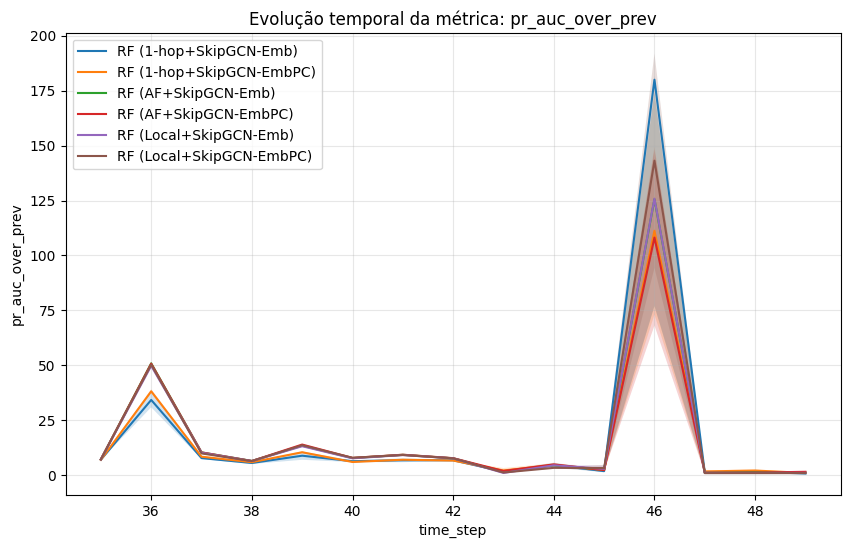

✅ Gráfico gerado para pr_auc_over_prev.  Troque o valor de 'metric' para outras métricas, como 'gini', 'f1', 'recall', etc.


In [49]:
import matplotlib.pyplot as plt

# ==========================================================
# 1) Monta DataFrame detalhado de métricas por time_step
# ==========================================================
records = []
for model_name, runs in results_summary_skipgcn.items():
    for r in runs:
        seed = r["seed"]
        for rec in r["por_time_step"]:
            rec = rec.copy()
            rec["Modelo"] = model_name
            rec["seed"] = seed
            records.append(rec)

df_time = pd.DataFrame(records)

# ==========================================================
# 2) Cálculo de média e desvio por modelo/time_step
# ==========================================================
metric = "pr_auc_over_prev"  # pode trocar para "gini", "f1", etc.
df_plot = (
    df_time.groupby(["Modelo", "time_step"])[metric]
    .agg(["mean", "std"])
    .reset_index()
)

# ==========================================================
# 3) Gráfico de evolução temporal
# ==========================================================
plt.figure(figsize=(10, 6))
for model_name, df_m in df_plot.groupby("Modelo"):
    plt.plot(df_m["time_step"], df_m["mean"], label=model_name)
    plt.fill_between(
        df_m["time_step"],
        df_m["mean"] - df_m["std"],
        df_m["mean"] + df_m["std"],
        alpha=0.2
    )

plt.title(f"Evolução temporal da métrica: {metric}")
plt.xlabel("time_step")
plt.ylabel(metric)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"✅ Gráfico gerado para {metric}.  "
      f"Troque o valor de 'metric' para outras métricas, como 'gini', 'f1', 'recall', etc.")


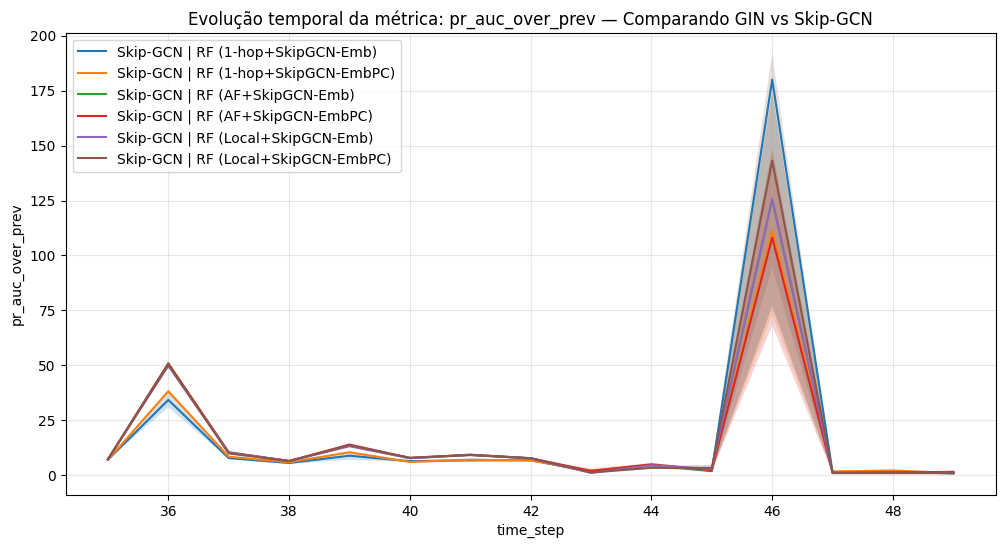

✅ Gráfico gerado para pr_auc_over_prev.
💡 Dica: troque o valor de 'metric' para 'gini', 'f1', 'recall', 'precision', ou 'pr_auc' para outras comparações.


In [50]:
import matplotlib.pyplot as plt

# ==========================================================
# 1) Combina resultados GIN + Skip-GCN
# ==========================================================
def collect_time_records(results_dict, label_prefix):
    records = []
    for model_name, runs in results_dict.items():
        if not model_name.startswith("RF"):
            continue
        for r in runs:
            seed = r["seed"]
            for rec in r["por_time_step"]:
                rec = rec.copy()
                rec["Modelo"] = f"{label_prefix} | {model_name}"
                rec["seed"] = seed
                records.append(rec)
    return records

records_all = (
    collect_time_records(results_summary, "GIN") +
    collect_time_records(results_summary_skipgcn, "Skip-GCN")
)
df_time_all = pd.DataFrame(records_all)

# ==========================================================
# 2) Agrupa por modelo e time_step (média ± desvio)
# ==========================================================
metric = "pr_auc_over_prev"  # troque por "gini", "f1", "recall", etc.
df_plot_all = (
    df_time_all.groupby(["Modelo", "time_step"])[metric]
    .agg(["mean", "std"])
    .reset_index()
)

# ==========================================================
# 3) Gráfico de evolução temporal (GIN vs Skip-GCN)
# ==========================================================
plt.figure(figsize=(12, 6))
for model_name, df_m in df_plot_all.groupby("Modelo"):
    plt.plot(df_m["time_step"], df_m["mean"], label=model_name)
    plt.fill_between(
        df_m["time_step"],
        df_m["mean"] - df_m["std"],
        df_m["mean"] + df_m["std"],
        alpha=0.2
    )

plt.title(f"Evolução temporal da métrica: {metric} — Comparando GIN vs Skip-GCN")
plt.xlabel("time_step")
plt.ylabel(metric)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"✅ Gráfico gerado para {metric}.")
print("💡 Dica: troque o valor de 'metric' para 'gini', 'f1', 'recall', 'precision', ou 'pr_auc' para outras comparações.")
